In [ ]:
# import pandas as pd

# # Cấu hình
# input_file = "D:\Clothing_Shoes_and_Jewelry\Clothing_Shoes_and_Jewelry.jsonl"  
# chunk_size = 1_000_000          

# # Đọc theo từng khúc và lưu thành nhiều file Parquet
# chunks = pd.read_json(input_file, lines=True, chunksize=chunk_size)

# for i, chunk in enumerate(chunks):
#     chunk.to_parquet(f"Clothing_Shoes_and_Jewelry_{i}.parquet",engine="pyarrow", index=False)
#     print(f"Đã lưu file số", i)


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Sales Forecasting") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
    
df = spark.read.json("D:\Clothing_Shoes_and_Jewelry\Clothing_Shoes_and_Jewelry.jsonl")

# splits = df.randomSplit([1.0/10] * 10, seed=42)

# for i, split in enumerate(splits):
#     split.write.mode("overwrite").parquet(f"parquet_parts/part_{i}")



In [4]:
df.show(5)

+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B096S6LZV4|           0|[{IMAGE, https://...| B09NSZ5QMF|   3.0|Unfortunately Ama...|1677938767351|Arrived Damaged :...|AFKZENTNBQ7A7V7UX...|             true|
|B09KMDBDCN|           0|                  []| B08NGL3X17|   3.0|Useless under 40 ...|1677083819242|Useless under 40 ...|AFKZENTNBQ7A7V7UX...|            false|
|B096N5WK8Q|          11|                  []| B07RGM3DYC|   4.0|I purchased these...|1675524098918|Not waterproof, b...|AFKZENTNBQ7A7V7UX...|             true|
|B07JR4QBZ4|          26|[{IMAGE, 

In [5]:
from pyspark.sql.functions import to_date, from_unixtime, col, count

# Tiền xử lý: chuyển timestamp sang ngày
df = df.withColumn("date", to_date(from_unixtime(col("timestamp") / 1000)))


# 4. Tìm mã ASIN có nhiều đánh giá nhất
asin_counts = df.groupBy("parent_asin").agg(count("*").alias("num_reviews"))
top_asin = asin_counts.orderBy(col("num_reviews").desc()).limit(1)
asin_target = top_asin.collect()[0]["parent_asin"]
print("ASIN có nhiều đánh giá nhất:", asin_target)


ASIN có nhiều đánh giá nhất: B07TVHSDMQ


In [6]:
# 5. Lọc dữ liệu theo ASIN được chọn
df = df.filter(col("parent_asin") == asin_target)

In [7]:
# 6. Nhóm theo ngày → đếm số lượt đánh giá/ngày (proxy cho lượt mua)
daily_sales = df.groupBy("date").count().orderBy("date")

In [8]:
# 7. Chuyển sang Pandas để huấn luyện mô hình
df_pd = daily_sales.toPandas()
df_pd = df_pd.dropna()
df_pd.reset_index(drop=True, inplace=True)

print(df_pd.shape)

(2095, 2)


In [9]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 1. Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df_pd["count"].values.reshape(-1, 1))

# 2. Tạo chuỗi đầu vào cho LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 14  # sử dụng 14 ngày gần nhất để dự báo ngày tiếp theo
X, y = create_sequences(sales_scaled, SEQ_LENGTH)

# 3. Chuyển sang tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  # [batch_size, seq_length, hidden_size]
        out = self.fc(out[:, -1, :])     # Lấy output tại thời điểm cuối cùng
        return out


In [11]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 150
for epoch in range(EPOCHS):
    model.train()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")


Epoch 10/150, Loss: 0.031650
Epoch 20/150, Loss: 0.022981
Epoch 30/150, Loss: 0.007919
Epoch 40/150, Loss: 0.006924
Epoch 50/150, Loss: 0.005472
Epoch 60/150, Loss: 0.005316
Epoch 70/150, Loss: 0.005191
Epoch 80/150, Loss: 0.005113
Epoch 90/150, Loss: 0.005044
Epoch 100/150, Loss: 0.004989
Epoch 110/150, Loss: 0.004935
Epoch 120/150, Loss: 0.004881
Epoch 130/150, Loss: 0.004825
Epoch 140/150, Loss: 0.004764
Epoch 150/150, Loss: 0.004698


In [12]:
# Lấy chuỗi 14 ngày cuối để dự báo
last_seq = sales_scaled[-SEQ_LENGTH:]
last_seq = torch.tensor(last_seq.reshape(1, SEQ_LENGTH, 1), dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred = model(last_seq).item()

# Chuyển về giá trị gốc
predicted_count = scaler.inverse_transform([[pred]])[0][0]
print(f"Dự báo số lượt mua cho ngày tiếp theo: {predicted_count:.2f}")


Dự báo số lượt mua cho ngày tiếp theo: 2.62


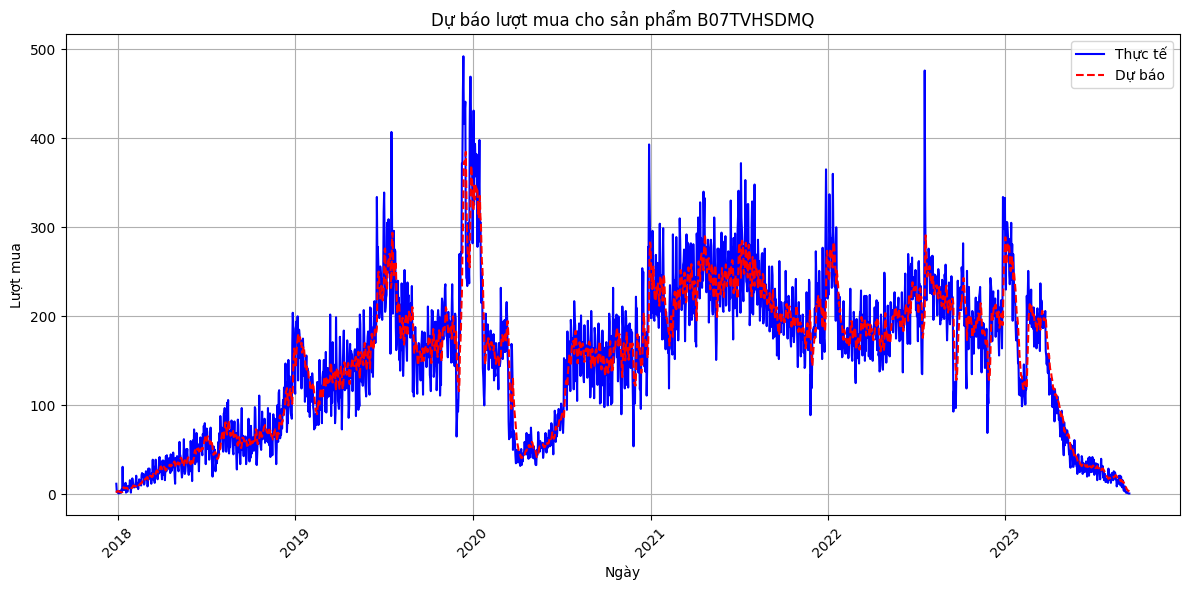

In [13]:
import matplotlib.pyplot as plt

# Dự báo toàn bộ chuỗi để so sánh (one-step ahead forecast)
model.eval()
with torch.no_grad():
    predicted_all = model(X_tensor).squeeze().numpy()

# Chuyển về giá trị gốc
predicted_all = scaler.inverse_transform(predicted_all.reshape(-1, 1)).flatten()
actual_all = scaler.inverse_transform(y_tensor.numpy().reshape(-1, 1)).flatten()

# Tạo mảng ngày tương ứng (từ ngày thứ SEQ_LENGTH trở đi)
dates = df_pd['date'].values[SEQ_LENGTH:]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_all, label='Thực tế', color='blue')
plt.plot(dates, predicted_all, label='Dự báo', color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title(f"Dự báo lượt mua cho sản phẩm {asin_target}")
plt.xlabel("Ngày")
plt.ylabel("Lượt mua")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


# Doanh Thu

In [14]:
# import pandas as pd
# import os
# import re

# def normalize_dict_keys(d):
#     if isinstance(d, dict):
#         new_dict = {}
#         for key, value in d.items():
#             clean_key = re.sub(r'[^\w]+', '_', key.strip().lower())
#             if clean_key in new_dict:
#                 i = 1
#                 while f"{clean_key}_{i}" in new_dict:
#                     i += 1
#                 clean_key = f"{clean_key}_{i}"
#             new_dict[clean_key] = normalize_dict_keys(value)
#         return new_dict
#     elif isinstance(d, list):
#         return [normalize_dict_keys(item) for item in d]
#     else:
#         return d

# def sanitize_columns(df):
#     # Chuẩn hóa toàn bộ tên cột dataframe
#     new_cols = []
#     seen = {}
#     for col in df.columns:
#         clean_col = re.sub(r"[^\w]+", "_", col.lower().strip())
#         if clean_col in seen:
#             seen[clean_col] += 1
#             clean_col = f"{clean_col}_{seen[clean_col]}"
#         else:
#             seen[clean_col] = 0
#         new_cols.append(clean_col)
#     df.columns = new_cols
#     return df

# chunksize = 200_000
# json_file = r"D:\Clothing_Shoes_and_Jewelry\meta_Clothing_Shoes_and_Jewelry.jsonl"
# output_dir = r"C:\Users\PC\OneDrive\Dokumen\python_programming\data\metadata"

# for i, chunk in enumerate(pd.read_json(json_file, lines=True, chunksize=chunksize)):
#     # Làm sạch keys trong cột 'details'
#     if 'details' in chunk.columns:
#         chunk['details'] = chunk['details'].apply(lambda d: normalize_dict_keys(d) if isinstance(d, dict) else d)

#     # Làm sạch tên cột toàn dataframe
#     chunk = sanitize_columns(chunk)

#     # Xử lý price
#     chunk['price'] = pd.to_numeric(chunk.get('price', pd.Series()), errors='coerce')

#     # Ghi lại
#     chunk.to_parquet(os.path.join(output_dir, f"meta_Clothing_Shoes_and_Jewelry_{i}.parquet"), index=False)


# Save to HDFS

In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .appName("SaveMultipleParquetToHDFS") \
#     .getOrCreate()

# df = spark.read.parquet(r"file:///C:\Users\PC\OneDrive\Dokumen\python_programming\data\metadata\meta_Clothing_Shoes_and_Jewelry_*.parquet")


In [ ]:
# df.write.mode("overwrite").parquet("hdfs://localhost:9000/user/mydata/combined_data.parquet")
